## Importando bibliotecas 

In [1]:
#Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import math
import config
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import KFold

#Importando as bibliotecas referentes ao XGBoost
import xgboost as xgb

#Biblioteca do Kmeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score


## Funções

### Modelos

In [2]:
#DecisionTree
def model_dtree(x_train,y_train,x_test, max_depth):
    bst = DecisionTreeRegressor(max_depth=max_depth).fit(x_train, y_train, max_depth)
    predict = bst.predict(x_test)
    return predict

#RandomForestRegressor
def model_randomForest(x_train,y_train,x_test,my_num, max_depth):
    #booster,eta,max_depth,colsample_bytree,subsample,min_child_weight,reg_lambda,num_boost):
    bst = RandomForestRegressor(n_estimators = my_num,n_jobs = -1, random_state=0, max_depth=max_depth).fit(x_train,y_train)
    predict = bst.predict(x_test)
    return predict

#SVR
#Não uso em nada
def model_svr(x_train,y_train,x_test,ker,gam,c,epsi,shrink,verb,max_it):
    bst = SVR(kernel=ker, gamma=gam, C=c, epsilon=epsi, shrinking=shrink, verbose=verb, max_iter=max_it).fit(x_train,y_train)
    predict = bst.predict(x_test)
    return predict

def model_multi_dtree(x_train, y_train, x_test):
    model = DecisionTreeRegressor()
    bst = MultiOutputRegressor(model).fit(x_train, y_train)
    predict = bst.predict(x_test)
    return predict

def model_xgboost(x_train, y_train, x_test):
    param = {'max_depth': 4,
             'eta': 0.05, 
             'objective': 'reg:squarederror',
             'booster': 'gbtree',
            }
    bst = xgb.XGBRegressor(**param, n_estimators=100)
    bst.fit(x_train, y_train) 
    predict = bst.predict(x_test)
    return predict

### Cálculo de erro 

In [3]:
def computer_RRMSE_list(real_test,result_p,real_train_mean):
    """RRMSE: Relative Root Mean Square Error
        input: real_test: real test data
              result_p: predicted data
              real_train_mean: mean of real train data
        output: RRMSE list """

    _list = []
    for i in range(result_p.shape[1]):
        fenzi = 0
        fenmu = 0
        for j in range(result_p.shape[0]):
            fenzi += (result_p[j,i] - real_test[j,i])**2
            fenmu += (real_train_mean[i] - real_test[j,i])**2
        _list.append(math.sqrt(fenzi/fenmu))    
    return _list

# def calculate_RRMSE(targets, valor, targets_mean):
#     loss_list_RRMSE = computer_RRMSE_list(targets, valor, targets_mean)
#     loss_list_RRMSE_np = np.array(loss_list_RRMSE)
#     mean_error = loss_list_RRMSE_np.mean(axis=0)
#     return mean_error

def calculate_RRMSE(targets, valor):
    targets_mean = np.mean(targets, axis=0)
    loss_list_RRMSE = computer_RRMSE_list(targets, valor, targets_mean)
    mean_error = np.array(loss_list_RRMSE).mean(axis=0)
    return mean_error


## Implementação

In [4]:
path = "../TCC/mtr-datasets/"

#text_file = input("dataset: ")
text_file = 'atp1d'
data, meta = loadarff(path + text_file + ".arff")
data = pd.DataFrame(data)

data.reset_index(inplace=True)
data.replace('?', np.nan, inplace=True)
data.replace('     ?', np.nan, inplace=True)
data = data.applymap(float)

#Normalização
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


if config.all_config[text_file].get('sample_random') == True:
    data = data.sample(frac=1,random_state = config.all_config[text_file].get('sample_random_num')).reset_index(drop=True)
data = data.fillna(pd.Series(np.nanmean(data,axis=0),index=data.columns))
label = data.iloc[:,-config.all_config[text_file].get('targets_num'):].values
data = data.iloc[:,:-config.all_config[text_file].get('targets_num')].values

#Lista para comparar resultados de teste no final
error_results = []

### Separação dos dados em Treino e Teste 


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)

# Variables to calculate RRMSE
# real_test_mean = y_test.mean(axis=0)
# real_train_mean = y_train.mean(axis=0)
label_mean = label.mean(axis=0)

### Baseline Regressor 


In [6]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

RRMSE_scorer = make_scorer(calculate_RRMSE, greater_is_better=False)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#### Random Forest e Decision Tree com cross validate 

In [42]:
score = cross_validate(RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state= 0), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
score

0.6249733671272005

In [41]:
score = cross_validate(DecisionTreeRegressor(), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
score

0.7273992142677389

Teste para definir bons parâmetros de decision tree

In [9]:
def find_best_param(param_name):
    errors = np.zeros(9)
    for i in range(1, 10):
        params = {'max_depth': i} if param_name == 'max_depth' else {'min_samples_leaf': i}
        score = cross_validate(DecisionTreeRegressor(**params), data, label, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        errors[i-1] = score

    min_score = np.min(errors)
    min_index = np.argmin(errors) + 1
    return min_index, min_score

best_max_depth, min_depth_score = find_best_param('max_depth')
best_min_samples_leaf, min_leaf_score = find_best_param('min_samples_leaf')

print("Best Max Depth: {}, Score: {:.5f}".format(best_max_depth, min_depth_score))
print("Best Min Samples Leaf: {}, Score: {:.5f}".format(best_min_samples_leaf, min_leaf_score))

Best Max Depth: 3, Score: 0.70765
Best Min Samples Leaf: 6, Score: 0.69388


In [10]:

matrix_errors = np.zeros((9, 9))  # Matriz de zeros para armazenar os erros

for i in range(1, 10):
    for j in range(1, 10):
        score = cross_validate(DecisionTreeRegressor(max_depth=i, min_samples_leaf=j), data, label, cv=kfold, scoring=RRMSE_scorer)
        score = np.sqrt(-score['test_score']).mean()
        matrix_errors[i-1][j-1] = score  # Salva o erro na posição correspondente da matriz

min_score = np.min(matrix_errors)  # Encontra o menor erro na matriz
best_max_depth, best_min_samples_leaf = np.unravel_index(np.argmin(matrix_errors), matrix_errors.shape)  # Encontra os índices do menor erro

print("Melhor valor para max_depth: {}, min_samples_leaf: {}".format(best_max_depth+1, best_min_samples_leaf+1))
print("Erro mínimo encontrado: {:.5f}".format(min_score))

Melhor valor para max_depth: 9, min_samples_leaf: 6
Erro mínimo encontrado: 0.69096


#### Decision Tree Local 

Esta errado pq nao esta usando cross validate 

In [11]:
def decision_tree(x_train, y_train):
    model = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf).fit(x_train, y_train)
    return model


scores = np.zeros(label.shape[1])

for target in range(label.shape[1]):

    score = cross_validate(decision_tree(data,label), data, label[:,target], cv=kfold, scoring=RRMSE_scorer)

    scores[target] = np.sqrt(-score['test_score']).mean()

print("Scores: ", scores)
print("Mean Score: ", scores.mean())


/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/var/folders/0f/cyrznsrn06xcrs6sr4j3d8100000gn/T/ipykernel_850/317816274.py", line 26, in calculate_RRMSE
    loss_list_RRMSE = computer_RRMSE_list(targets, valor, targets_mean)
  File "/var/folders/0f/cyrznsrn06xcrs6sr4j3d8100000gn/T/ipykernel_850/317816274.py", line 9, in computer_RRMSE_lis

Scores:  [nan nan nan nan nan nan]
Mean Score:  nan


/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/var/folders/0f/cyrznsrn06xcrs6sr4j3d8100000gn/T/ipykernel_850/317816274.py", line 26, in calculate_RRMSE
    loss_list_RRMSE = computer_RRMSE_list(targets, valor, targets_mean)
  File "/var/folders/0f/cyrznsrn06xcrs6sr4j3d8100000gn/T/ipykernel_850/317816274.py", line 9, in computer_RRMSE_lis

In [12]:
# AInda nao consegui fazer funcionar
# Decision tree local usando cross validation

# def calculate_RRMSE_local(targets, valor, targets_mean):
    
#     loss_list_RRMSE = computer_RRMSE_list(targets, valor, targets_mean)
#     loss_list_RRMSE_np = np.array(loss_list_RRMSE)
#     mean_error = loss_list_RRMSE_np.mean(axis=0)
#     return mean_error

# predicted_score = []

# for target in range(label.shape[1]):
#     label_mean = label[:, target].mean(axis=0)
#     RRMSE_scorer_local = make_scorer(calculate_RRMSE_local, greater_is_better=False, targets_mean=label_mean)
#     score = cross_validate(DecisionTreeRegressor(max_depth=3), data, label[:,target], cv=kfold, scoring=RRMSE_scorer_local)
#     score = score['test_score'].mean()
#     predicted_score.append(score)

#     # print(score)

# print(np.mean(predicted_score))
    


#### Multi Output Decision Tree

In [40]:
score = cross_validate(MultiOutputRegressor(DecisionTreeRegressor()), data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()

print("MultiOutputRegressor: ", score)

MultiOutputRegressor:  0.7206199024627673


### Matriz de Dissimilaridade 

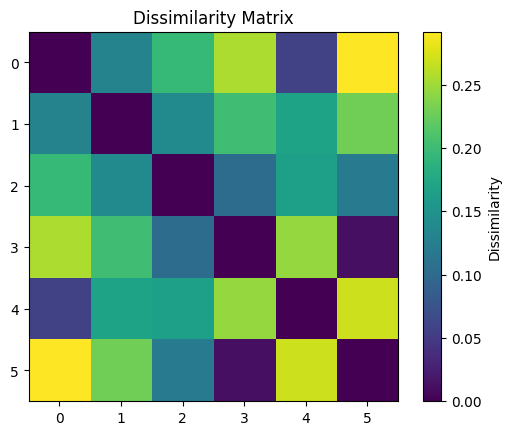

In [14]:
matriz_dissimilaridade = 1 - np.corrcoef(y_train.T)

plt.imshow(matriz_dissimilaridade, cmap='viridis')
plt.colorbar(label='Dissimilarity')
plt.title('Dissimilarity Matrix')
plt.show()

/var/folders/0f/cyrznsrn06xcrs6sr4j3d8100000gn/T/ipykernel_850/21108651.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matriz_dissimilaridade, method='average')


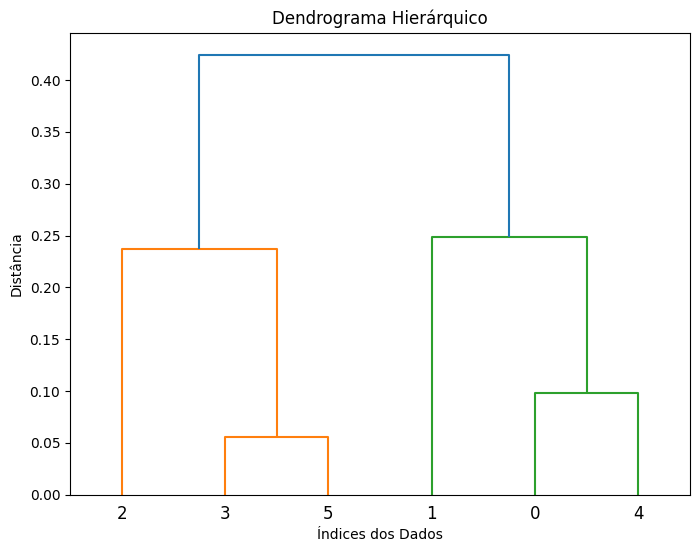

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# from scipy.spatial.distance import squareform

linkage_matrix = linkage(matriz_dissimilaridade, method='average')

plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Dendrograma Hierárquico')
plt.xlabel('Índices dos Dados')
plt.ylabel('Distância')
plt.show()

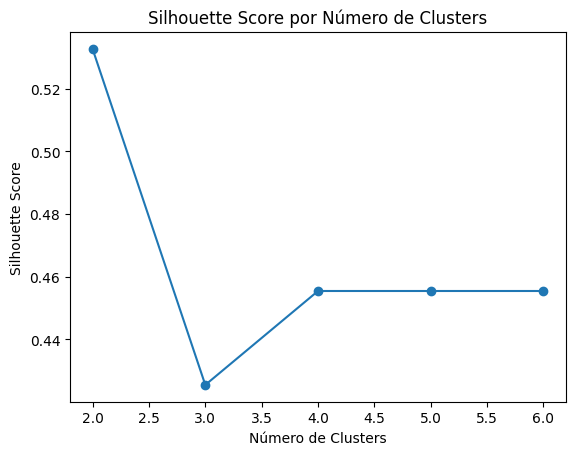

In [16]:
silhouette_scores = []

min_clusters = 2
if y_train.shape[1] < 10:
    max_clusters = y_train.shape[1]+1
else:
    max_clusters = 10

for n_clusters in range(min_clusters, max_clusters):
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    silhouette_scores.append(silhouette_score(matriz_dissimilaridade, cluster_labels))

plt.plot(range(min_clusters, max_clusters), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.show()


antigo

In [17]:
best_cut = silhouette_scores.index(max(silhouette_scores)) + min_clusters
print('Best number of clusters:', best_cut)

clusters = fcluster(linkage_matrix, best_cut, criterion='maxclust')

y_train_cluster = [[] for _ in range(max(clusters))]
y_test_cluster = [[] for _ in range(max(clusters))]

# Split the targets into clusters
for i, cluster in enumerate(clusters):
    y_train_cluster[cluster-1].append(y_train[:, i])
    print('Cluster: {}, Target: {}'.format(cluster, i))
    y_test_cluster[cluster-1].append(y_test[:, i]) 

Best number of clusters: 2
Cluster: 2, Target: 0
Cluster: 2, Target: 1
Cluster: 1, Target: 2
Cluster: 1, Target: 3
Cluster: 2, Target: 4
Cluster: 1, Target: 5


In [83]:
best_cut = silhouette_scores.index(max(silhouette_scores)) + min_clusters
print('Best number of clusters:', best_cut)

clusters = fcluster(linkage_matrix, best_cut, criterion='maxclust')

label_cluster = [[] for _ in range(max(clusters))]

# Split the targets into clusters
for i, cluster in enumerate(clusters):
    label_cluster[cluster-1].append(label[:, i])
    print('Cluster: {}, Target: {}'.format(cluster-1, i))

Best number of clusters: 2
Cluster: 1, Target: 0
Cluster: 1, Target: 1
Cluster: 0, Target: 2
Cluster: 0, Target: 3
Cluster: 1, Target: 4
Cluster: 0, Target: 5


#### Regressor Chain de Random forest Clusterizado

In [92]:
# Define the train_regressor function
def Chain_RandomForest():
    reg_chain = RegressorChain(RandomForestRegressor(random_state=0, n_jobs=-1))
    return reg_chain


errors = []
regressors = []
for i in range(len(y_train_cluster)):
    
    regressors.append(Chain_RandomForest())
    score = cross_validate(regressors[i], data, np.array(label_cluster[i]).T, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

print("Regressor chain of Random Forest Clusterizado: ", np.mean(errors))


Regressor chain of Random Forest:  0.6108789042568139


#### Regressor Chain de Decision Tree Clusterizado

In [97]:
# Define the train_regressor function
def Chain_DecisionTree():
    reg_chain = RegressorChain(DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf))
    return reg_chain


errors = []
regressors = []
for i in range(len(y_train_cluster)):
    regressors.append(Chain_DecisionTree())
    score = cross_validate(regressors[i], data, np.array(label_cluster[i]).T, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

print("Regressor chain of Decision Tree Clusterizado: ", np.mean(errors))

Regressor chain of Decision Tree Clusterizado:  0.6852034220839256


#### Random forest Clusterizado

In [100]:
def model_randomForest():
    regressor = RandomForestRegressor(n_estimators = 50,n_jobs = -1, random_state=0)
    return regressor

errors = []
regressors = []
for i in range(len(y_train_cluster)):
    regressors.append(model_randomForest())
    score = cross_validate(regressors[i], data, np.array(label_cluster[i]).T, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

print("Random Forest Clusterizado: ", np.mean(errors))

Random Forest Clusterizado:  0.6038325347822753


In [103]:
def model_dtree():
    regressor = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
    return regressor

errors = []
regressors = []
for i in range(len(y_train_cluster)):
    regressors.append(model_dtree())
    score = cross_validate(regressors[i], data, np.array(label_cluster[i]).T, cv=kfold, scoring=RRMSE_scorer)
    score = np.sqrt(-score['test_score']).mean()
    errors.append(score)
    # print(score)

print("Decision Tree Clusterizado: ", np.mean(errors))

Decision Tree Clusterizado:  0.6770787811375321


### Regressor Chain Padrão

In [90]:
#Define important variables
RANDOM_STATE = 0 

loss_list_RRMSE = []

reg_chain = RegressorChain(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
score = cross_validate(reg_chain, data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("Regressor chain of Random Forest: ", score)

Regressor chain of Random Forest Padrão:  0.6158861607891393


### Kmeans dos dados (Antigo)

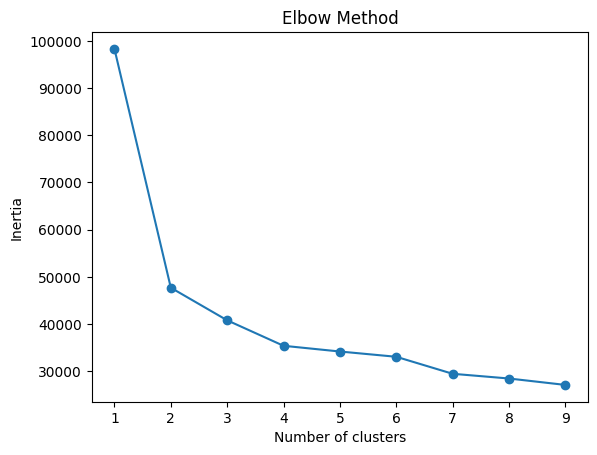

In [23]:
inertia_values = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto').fit(x_train)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [24]:
NUM_CLUSTER = config.all_config[text_file].get('num_cluster')
kmeans_optimal = KMeans(n_clusters=NUM_CLUSTER, random_state=0, n_init='auto').fit(x_train)
cluster_labels = kmeans_optimal.labels_

#### Kmeans só dos targets

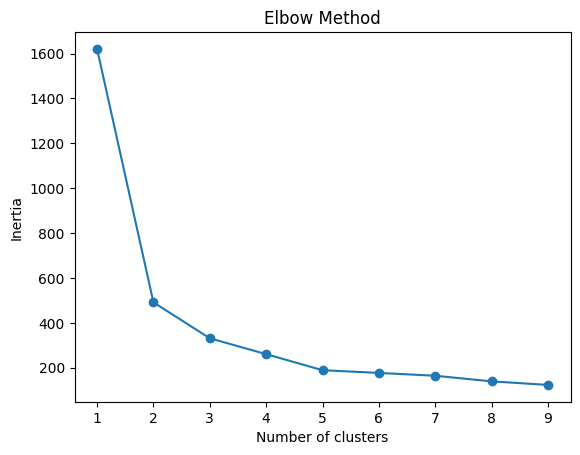

In [25]:
inertia_values = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init='auto').fit(y_train)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [26]:
k_optimal = config.all_config[text_file].get("num_cluster_targets")
kmeans_optimal = KMeans(n_clusters=k_optimal, random_state=0, n_init='auto').fit(y_train)

cluster_labels_target = kmeans_optimal.labels_

#### Regressor Chain pelos grupos dos Kmeans

In [27]:
# Define the train_regressor function
def train_regressor(cluster_data, label):
    indices = cluster_data.index
    y_cluster = label[indices]

    reg_chain = RegressorChain(RandomForestRegressor(random_state=RANDOM_STATE))
    reg_chain.fit(cluster_data, y_cluster)  

    y_pred = reg_chain.predict(cluster_data)

    real_train_mean_cluster = y_cluster.mean(axis=0)

    error = calculate_RRMSE(y_cluster, y_pred, real_train_mean_cluster)
   
    print(error)

    return reg_chain

Caso de treino

In [28]:
# Create a DataFrame with x_train data
data_cluster = pd.DataFrame(x_train)
data_cluster['cluster'] = cluster_labels

# Split the data into clusters
train_cluster = {cluster_label: data_cluster[data_cluster['cluster'] == cluster_label].drop(['cluster'], axis=1) for cluster_label in range(NUM_CLUSTER)}

# Train regressors for each cluster
trained_regressors = {cluster_label: train_regressor(cluster_train_data, label) for cluster_label, cluster_train_data in train_cluster.items()}

TypeError: calculate_RRMSE() takes 2 positional arguments but 3 were given

Caso de teste

In [ ]:
y_pred_dict = {cluster_label: regressor.predict(x_test) for cluster_label, regressor in trained_regressors.items()}
error = np.array([])

for chave, value in y_pred_dict.items():
    error_RRMSE = calculate_RRMSE(y_test, y_pred_dict[chave], real_test_mean)
    error = np.append(error, error_RRMSE)


RRMSE = error.mean(axis=0)
print(RRMSE)

# List to store the results
error_results.append(('Regressor Chain Cluster', RRMSE))

1.6601984753697885


### Ensemble Regressor Chain 

Caso de treino

In [ ]:
num_chain = label.shape[1]

ensemble = [RegressorChain(RandomForestRegressor(random_state=i)) for i in range(num_chain)]
reg_chains = [reg_chain.fit(x_train, y_train[:, [i]]) for i, reg_chain in enumerate(ensemble)]
y_preds = np.column_stack([reg_chain.predict(x_train) for reg_chain in reg_chains])

error = calculate_RRMSE(y_train, y_preds, real_train_mean)
print("Caso de Treino: ", error)

# Caso de teste

y_preds = []
y_preds = np.column_stack([reg_chain.predict(x_test) for reg_chain in reg_chains])

error = calculate_RRMSE(y_test, y_preds, real_test_mean)
print("Caso de Teste: ",error)

error_results.append(('Ensemble de Regressor Chain', error))

Caso de Treino:  0.13862822217430446
Caso de Teste:  0.3975720859837461


## Modelos

#### XGBoost Local

!!! Colocar da mesma forma q os outros !!!

In [105]:
def model_xgboost(x_train, y_train):
    param = {'max_depth': 4,
             'eta': 0.05, 
             'objective': 'reg:squarederror',
             'booster': 'gbtree',
            }
    bst = xgb.XGBRegressor(**param, n_estimators=100)
    bst.fit(x_train, y_train) 
    return bst


xgboost = model_xgboost(data, label)
score = cross_validate(xgboost, data, label, cv=kfold, scoring=RRMSE_scorer)
score = np.sqrt(-score['test_score']).mean()
print("XGBoost: ", score)

XGBoost:  0.6100128516029643


In [ ]:
loss_list_RRMSE = []

kf = KFold(n_splits=config.all_config[text_file].get('paper_kFold'),
            shuffle=config.all_config[text_file].get('kfold_random'),
            random_state=config.all_config[text_file].get('kfold_random_num'))

for train_index, test_index in kf.split(data):
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    result_p_train = model_xgboost(x_train, y_train, x_test)
    
    real_train_mean = y_train.mean(axis=0)    
    loss_list_RRMSE.append(computer_RRMSE_list(y_test, result_p_train, real_train_mean))

loss_list_RRMSE_np = np.array(loss_list_RRMSE)
error_results.append(('XGBoost Local', loss_list_RRMSE_np.mean(axis=0)))
# print('RRMSE: ', loss_list_RRMSE_np)
print('RRMSE mean: ', loss_list_RRMSE_np.mean(axis=0))

RRMSE mean:  [0.49146055 0.49935981 0.40610491 0.21972201 0.49727372 0.19733626]


In [ ]:
# print the name and value of each model's error result
for model, error in error_results:
    print(f'{model} RRMSE: {error}')

Regressor Chain Padrão RRMSE: 0.4154982687282572
Regressor Chain Cluster RRMSE: 1.6601984753697885
Ensemble de Regressor Chain RRMSE: 0.3975720859837461
MultiOutput Decision Tree:  RRMSE: 0.43959964356259484
XGBoost Local RRMSE: [0.49146055 0.49935981 0.40610491 0.21972201 0.49727372 0.19733626]
